In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

## import raw data

In [96]:
df = pd.read_excel('../database/export_binance/df_new.xlsx', index_col=0)
df.head(3)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
1,1,2021-05-31 09:00:00,Spot,Deposit,SOL,25.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BTC,1.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BNB,35.0,NaN


## spot wallet

### wallet balance overview

In [97]:
#spot balance per coin, enhanced with a current price in USDT
df_spot = df.loc[df['Account'] == 'Spot']
balance_spot = df_spot.groupby('Coin').sum()['Change']
df_current_prices = pd.read_excel('../database/prices/current_prices.xlsx', index_col=0)
holding_prices = []
for i in balance_spot.index:
    if i == 'USDT':
        holding_prices.append(1)
    else:
        try:
            price = df_current_prices.loc[df_current_prices['symbol'] == (i + 'USDT')]['price'].values[0]
            holding_prices.append(price)
        except:
            holding_prices.append(np.nan)
balance_spot = pd.DataFrame(balance_spot)
balance_spot['USDT_price'] = holding_prices
balance_spot['USDT_value'] = holding_prices * balance_spot['Change']
print(f'current total value: {round(balance_spot["USDT_value"].sum(), 2)} USDT')
balance_spot.sort_values(by='USDT_value', ascending=False, inplace=True)
balance_spot.loc[balance_spot['USDT_value'] > 1]

current total value: 82620.71 USDT


,Change,USDT_price,USDT_value
Coin,,,
BTC,1.372650,30153.4700,41390.155469
BUSD,21403.548085,1.0007,21418.530568
USDT,4416.448950,1.0000,4416.448950
ETH,2.299233,1786.2500,4107.005589
BNB,9.426420,287.9000,2713.866399
CAKE,454.660000,4.4380,2017.781080
AVAX,59.720000,24.0800,1438.057600
MANA,1100.000000,0.9811,1079.210000
LUNA,335.150000,2.9918,1002.701770


### monthly spot balance in usdt

In [100]:
#get monthly final balance per coin
df_spot['year_month'] = df_spot['UTC_Time'].dt.strftime('%Y-%m')
monthly_bal = df_spot.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
monthly_bal = monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
monthly_bal = monthly_bal.cumsum()

#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

end_dates = []
for i in monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)

#join prices and balances to get value in USDT
join = monthly_bal.join(monthly_prices, how='outer')
for i in monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join[i] = join[i] * join[name_price]
join.drop(monthly_prices.columns, axis=1, inplace=True)
join['total_value'] = join.sum(axis=1)
join

,AAVE,ADA,ATOM,AUDIO,AVAX,BETA,BNB,BTC,BUSD,CAKE,...,RUNE,SAND,SOL,SUSHI,UNI,USDC,USDT,WETH,XTZ,total_value
year_month,,,,,,,,,,,,,,,,,,,,,
2021-05,0.00,0.00000,0.000000e+00,0.0,0.0000,0.000000e+00,12366.550000,37253.810000,49985.000000,0.00000,...,0.0,0.000000e+00,818.7500,0.000000e+00,0.000000e+00,0.000000,50000.000000,0.0,0.0,150424.110000
2021-06,0.00,0.00000,0.000000e+00,0.0,0.0000,0.000000e+00,10629.850000,35045.000000,47727.988723,0.00000,...,0.0,0.000000e+00,887.7500,0.000000e+00,0.000000e+00,0.000000,50000.000000,0.0,0.0,146074.102512
2021-07,0.00,0.00000,0.000000e+00,0.0,1082.0000,0.000000e+00,11627.793687,41461.830000,47196.649648,0.00000,...,0.0,0.000000e+00,918.6000,0.000000e+00,0.000000e+00,0.000000,44980.921814,0.0,0.0,154552.904033
2021-08,2389.37,0.00000,-8.132162e-14,369.0,0.0000,0.000000e+00,16193.198340,48632.364134,48198.907723,0.00000,...,0.0,1.354863e-13,11087.9307,6.026500e+02,1.043787e-13,0.000000,35845.484340,0.0,0.0,176254.425337
2021-09,303.93,2411.10000,-1.287148e-13,839.2,14074.9212,0.000000e+00,24095.025346,55281.900865,4579.224840,8597.64235,...,0.0,5.031750e+02,11045.2381,5.078000e+02,8.359535e-14,0.000000,27063.884340,0.0,0.0,182047.897315
2021-10,345.62,2238.96000,-1.323031e-13,444.6,3851.9400,1.710783e+02,5859.676193,78677.148833,2540.115182,8024.74900,...,0.0,1.785907e-13,12783.1937,-1.549125e-13,8.874679e-14,0.000000,20513.110540,0.0,0.0,197663.459580
2021-11,282.37,334.11000,-9.773515e-14,459.8,7190.8852,1.264229e+02,6947.238581,76796.766893,5030.070193,6369.78660,...,0.0,7.722065e-13,13164.4989,-1.137010e-13,7.549517e-14,0.000000,6398.674812,0.0,0.0,186594.178217
2021-12,279.29,-111.18000,1.144339e+03,320.2,6535.1596,6.132564e+01,5654.613106,63439.661108,17160.651408,5337.70840,...,0.0,6.640335e-13,8181.6187,-1.339373e-13,6.039613e-14,0.000000,6888.624908,0.0,0.0,171305.810379
2022-01,173.25,-89.33500,9.910151e+02,184.0,4172.6364,1.117456e-14,4135.757223,52801.583746,20746.540973,3359.93740,...,0.0,4.654794e-13,4283.0445,-5.995560e-14,4.181544e-14,0.000000,1490.617069,0.0,0.0,129168.847761


### monthly funding balance in USDT

In [102]:
investmenst = df_spot.loc[(df_spot['Operation'] == 'Deposit') | (df_spot['Operation'] == 'Withdraw') | (df_spot['Operation'] == 'transfer_in') | (df_spot['Operation'] == 'transfer_out')]
inv_monthly_bal = investmenst.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
inv_monthly_bal = inv_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#inv_monthly_bal = inv_monthly_bal.cumsum()

col = []
for i in inv_monthly_bal.columns.drop('USDT'):
    name_price = i + 'USDT'
    col.append(name_price)
    
end_dates = []
for i in inv_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
inv_monthly_prices = df_hist_prices.loc[end_dates].reset_index()
inv_monthly_prices['datetime'] = inv_monthly_prices['datetime'].dt.strftime('%Y-%m')
inv_monthly_prices.set_index('datetime', inplace=True)
inv_monthly_prices = inv_monthly_prices.loc[:,col]
print(inv_monthly_prices.shape)
inv_monthly_prices.head(3)

join_inv = inv_monthly_bal.join(inv_monthly_prices, how='outer')
for i in inv_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join_inv[i] = join_inv[i] * join_inv[name_price]
join_inv.drop(inv_monthly_prices.columns, axis=1, inplace=True)
join_inv['total_value'] = join_inv.sum(axis=1)
join_inv['total_value'] = join_inv['total_value'].cumsum()
print(join_inv.shape)
join_inv.head(10)

(10, 11)
(10, 13)


,AVAX,BNB,BTC,BUSD,CAKE,ETH,EUR,FTM,SOL,USDC,USDT,WETH,total_value
year_month,,,,,,,,,,,,,
2021-05,0.0,12366.550,37253.81,49985.000000,0.000000,0.000000,0.00000,0.000,818.75,0.000000,50000.000000,0.000000,150424.110000
2021-08,0.0,0.000,0.00,0.000000,0.000000,0.000000,-746.72213,0.000,0.00,0.000000,0.000000,0.000000,149677.387870
2021-09,0.0,-19.375,0.00,0.000000,8597.642350,0.000000,-1157.00000,0.000,0.00,0.000000,-6216.000000,0.000000,150882.655220
2021-10,-12900.0,0.000,0.00,1569.164485,-7453.322488,-4993.635842,0.00000,-9242.205,0.00,0.000000,-4381.809200,4993.635842,118474.483018
2021-11,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.00000,0.000,0.00,0.000000,-14078.352028,0.000000,104396.130990
2021-12,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.00000,0.000,0.00,0.000000,489.950096,0.000000,104886.081087
2022-01,0.0,0.000,0.00,0.000000,0.000000,0.000000,652.27470,0.000,0.00,0.000000,-6552.717139,0.000000,98985.638648
2022-02,0.0,0.000,0.00,0.000000,0.000000,-4514.036130,0.00000,0.000,0.00,0.000000,3000.000000,0.000000,97471.602518
2022-04,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.00000,0.000,0.00,477.809366,-1226.907331,0.000000,96722.504552


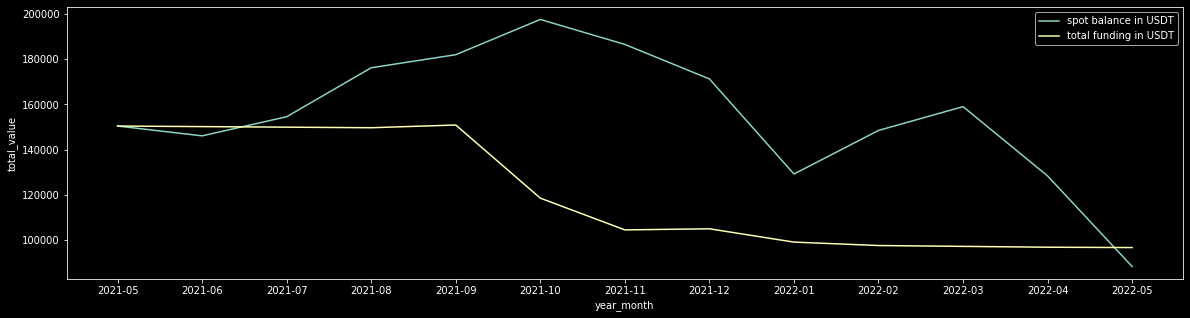

In [103]:
#plot monthly balance in USDT and investment in USDT
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=join.index, y='total_value', data=join, label='spot balance in USDT')
sns.lineplot(x=join_inv.index, y='total_value', data=join_inv, label='total funding in USDT');

In [ ]:
#que moneda es la que afecta mas

## trades

### trades per coin plot

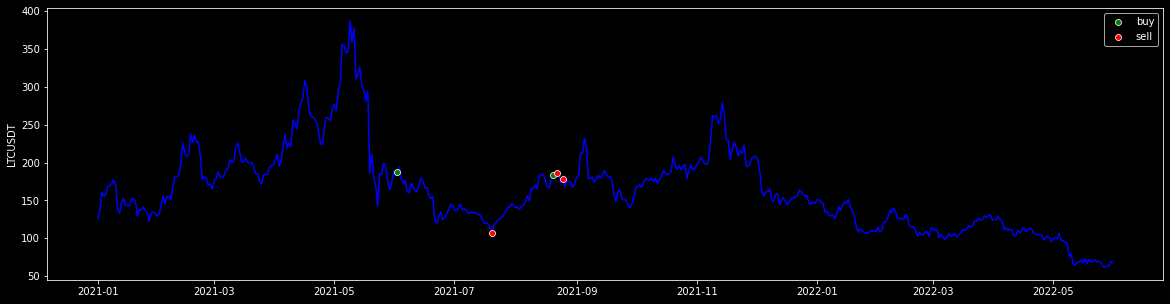

In [106]:
#import prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

#get trade related operations
trades = df.loc[((df['Operation'] == 'Buy')) | ((df['Operation'] == 'Sell')) | ((df['Operation'] == 'Large OTC trading')) | ((df['Operation'] == 'Small assets exchange BNB')) | ((df['Operation'] == 'Transaction Related'))]
#separate columns for buy and sell and cut time from datetime
trades['buy'] = trades['Change'].apply(lambda x: x if x > 0 else np.nan)
trades['sell'] = trades['Change'].apply(lambda x: x if x < 0 else np.nan)
trades['UTC_Time'] = trades['UTC_Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
trades = trades[['UTC_Time', 'buy', 'sell', 'Coin']].set_index('UTC_Time').sort_values(by=['Coin', 'buy'])
#delete duplicated dates
trades = trades.reset_index().groupby(['UTC_Time', 'Coin']).agg({'buy': 'sum', 'sell': 'sum'}).reset_index().sort_values(by=['Coin', 'UTC_Time'])
trades = trades.replace(0,np.nan)
trades['UTC_Time'] = pd.to_datetime(trades['UTC_Time'])
trades.set_index('UTC_Time', inplace=True)

#integrate historical prices with trades
for i in trades['Coin'].unique():
    buy_name = i + '_buy'
    sell_name = i + '_sell'
    temp = trades.loc[trades['Coin'] == i]
    temp[buy_name] = temp['buy']
    temp[sell_name] = temp['sell']
    temp.drop(['Coin', 'buy', 'sell'], axis=1, inplace=True)
    df_hist_prices = pd.merge(df_hist_prices, temp, how='outer', left_index=True, right_index=True)

#plot trades and prices (input coin name)
def plot_trades(df, coin):

    price_name = coin + 'USDT'
    buy_name = coin + '_buy'
    sell_name = coin + '_sell'

    temp = df_hist_prices[[price_name, buy_name, sell_name]]
    temp = temp.loc[(temp[buy_name] > 0) | (temp[sell_name] < 0)]

    temp[buy_name] = temp[buy_name].apply(lambda x: 1 if x > 0 else np.nan)
    temp[sell_name] = temp[sell_name].apply(lambda x: 1 if x < 0 else np.nan)
    temp[buy_name] = temp[buy_name] * temp[price_name]
    temp[sell_name] = temp[sell_name] * temp[price_name]

    fig = plt.figure(figsize=(20, 5))
    sns.lineplot(x=df.index, y=price_name, data=df, color='blue')
    sns.lineplot(x=temp.index, y=buy_name, data=temp, color='g', marker='o', label='buy', linestyle='')
    sns.lineplot(x=temp.index, y=sell_name, data=temp, color='r', marker='o', label='sell', linestyle='');
    plt.legend()
    plt.show()
plot_trades(df_hist_prices, input('coin: '))

### trades analysis

In [ ]:
#number of total trades

### piechart

In [107]:
#coin distribution
import plotly.express as px